# Retail Data Wrangling and Analytics

In [0]:
# Import modules 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Load CSV into Dataframe
Alternatively, the LGS IT team also dumped the transactional data into a [CSV file](https://raw.githubusercontent.com/jarviscanada/jarvis_data_eng_demo/feature/data/python_data_wrangling/data/online_retail_II.csv). However, the CSV header (column names) doesn't follow the snakecase or camelcase naming convention (e.g. `Customer ID` instead of `customer_id` or `CustomerID`). As a result, you will need to use Pandas to clean up the data before doing any analytics. In addition, unlike the PSQL scheme, CSV files do not have data types associated. Therefore, you will need to cast/convert certain columns into correct data types (e.g. DateTime, numbers, etc..)

**Data Preperation**

- Read the `data/online_retail_II.csv` file into a DataFrame
- Rename all columns to upper camelcase or snakecase
- Convert/cast all columns to the appropriate data types (e.g. datetime)

In [0]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, FloatType

schema = StructType([
    StructField("Invoice", StringType(), True), 
    StructField("StockCode", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Quantity", IntegerType(), True),
    StructField("InvoiceDate", TimestampType(), True),
    StructField("Price", FloatType(), True),
    StructField("Customer ID", FloatType(), True),
    StructField("Country", StringType(), True)
])
file_location = "dbfs:/FileStore/tables/online_retail_II.csv"
retail_df = spark.read.format("csv").option("header", "true").schema(schema).load(file_location)
retail_df = (retail_df
             .withColumnRenamed("Invoice", "invoice")
             .withColumnRenamed("StockCode", "stock_code")
             .withColumnRenamed("Description", "description")
             .withColumnRenamed("Quantity", "quantity")
             .withColumnRenamed("InvoiceDate", "invoice_date")
             .withColumnRenamed("Price", "price")
             .withColumnRenamed("Customer ID", "customer_id")
             .withColumnRenamed("Country", "country")
)
spark.sql("DROP TABLE IF EXISTS online_retail_ii")
retail_df.write.mode("overwrite").saveAsTable("online_retail_ii")
retail_df.show()

+-------+----------+--------------------+--------+-------------------+-----+-----------+--------------+
|invoice|stock_code|         description|quantity|       invoice_date|price|customer_id|       country|
+-------+----------+--------------------+--------+-------------------+-----+-----------+--------------+
| 489434|     85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00| 6.95|    13085.0|United Kingdom|
| 489434|    79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|    79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|     22041|"RECORD FRAME 7""...|      48|2009-12-01 07:45:00|  2.1|    13085.0|United Kingdom|
| 489434|     21232|STRAWBERRY CERAMI...|      24|2009-12-01 07:45:00| 1.25|    13085.0|United Kingdom|
| 489434|     22064|PINK DOUGHNUT TRI...|      24|2009-12-01 07:45:00| 1.65|    13085.0|United Kingdom|
| 489434|     21871| SAVE THE PLANET MUG|      24|2009-12-01 07:

# Total Invoice Amount Distribution


Find the total amount per invoice

In [0]:
from pyspark.sql.functions import sum

invoice = spark.sql("SELECT * FROM online_retail_ii")
# Filter the data to remove negative values
invoice = invoice.filter("price > 0 AND quantity > 0")
# Calculate the total price for each row
invoice = invoice.withColumn("total_price", invoice.quantity * invoice.price)

#Grouping the data by invoice and summing the total_price
invoice = invoice.groupBy("invoice").agg(sum("total_price").alias("total_price"))
invoice.show()


+-------+------------------+
|invoice|       total_price|
+-------+------------------+
| 502860|106.96000170707703|
| 503942| 304.3299980163574|
| 504328|355.18999540805817|
| 504372|315.85000228881836|
| 505024|216.54000103473663|
| 505703|328.48000049591064|
| 506092|105.71000051498413|
| 506258| 306.1999979019165|
| 507206| 673.8599939346313|
| 507464| 1621.800048828125|
| 508195|207.36001586914062|
| 508647|              60.0|
| 508840|112.93999806046486|
| 508905|160.40000343322754|
| 508953|100.80000305175781|
| 509891|              4.25|
| 510434|30.500000715255737|
| 510436|180.64999771118164|
| 510516|270.04999923706055|
| 510761| 65.04999804496765|
+-------+------------------+
only showing top 20 rows



Minimum: 0.19
Mean: 523.3
Median: 304.31
Mode: 15.0
Maximum: 168469.59


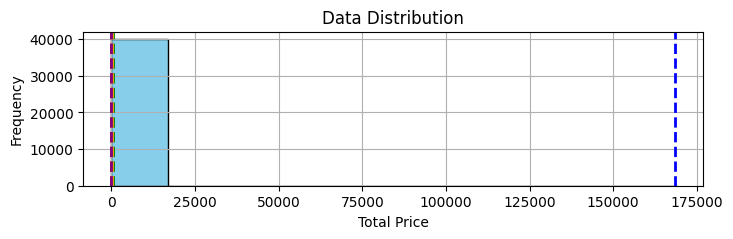

In [0]:
# Convert pyspark dataframe to pandas dataframe
invoice_pd = invoice.select("total_price").toPandas()

# Calculate summary statistics on the invoice dataframe
min = invoice_pd["total_price"].min()
mean = invoice_pd["total_price"].mean()
median = invoice_pd["total_price"].median()
mode = invoice_pd["total_price"].mode()[0]
max = invoice_pd["total_price"].max()

# Plot the histogram of the total_price column
plt.figure(figsize=(8, 2))
plt.hist(invoice_pd["total_price"], bins=10, color='skyblue', edgecolor='black')

# Add summary statistics to the histogram plot
plt.axvline(min, color='red', linestyle='dashed', linewidth=2, label='Minimum')
plt.axvline(mean, color='green', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(median, color='orange', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(mode, color='purple', linestyle='dashed', linewidth=2, label='Mode')
plt.axvline(max, color='blue', linestyle='dashed', linewidth=2, label='Maximum')

plt.title("Data Distribution")
plt.xlabel("Total Price")
plt.ylabel("Frequency")
plt.grid(True)

print("Minimum:", round(min, 2))
print("Mean:", round(mean, 2))
print("Median:", round(median, 2))
print("Mode:", round(mode, 2))
print("Maximum:", round(max, 2))

plt.show()

Remove outliers by using the first 85 quantiles of the data

Minimum: 0.19
Mean: 271.68
Median: 256.23
Mode: 15.0
Maximum: 724.25


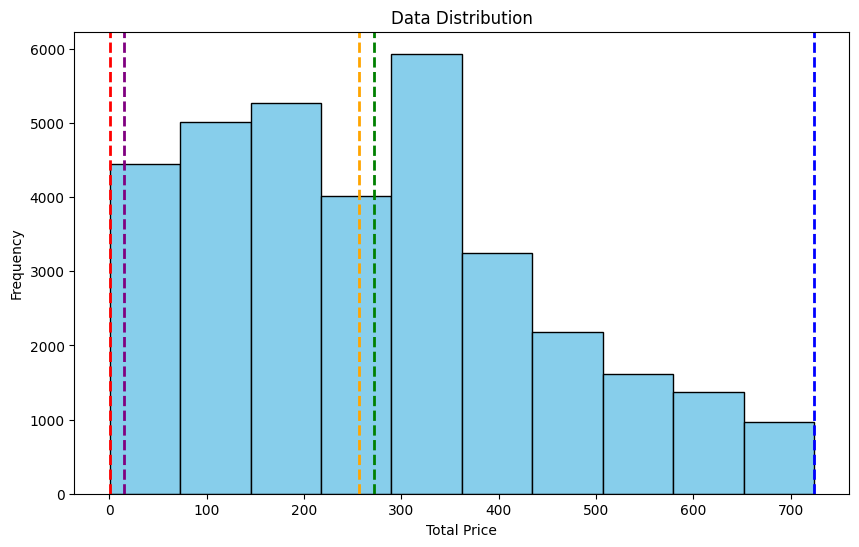

In [0]:
# Convert pyspark dataframe to pandas dataframe
invoice_pd = invoice.select("total_price").toPandas()

# Calculate the first 85 quantiles (from 1st percentile to 85th percentile)
quantiles = np.quantile(invoice_pd["total_price"], np.linspace(0, 0.85, 86))

# Define the minimum and maximum value for the x-axis from the quantiles
min_value = quantiles[0]
max_value = quantiles[-1]

# Filter the dataframe to include only values between the min and max quantile values
invoice_pd = invoice_pd[invoice_pd["total_price"].between(min_value, max_value)]

# Calculate the summary statistics for the filtered dataframe
min = invoice_pd["total_price"].min()
mean = invoice_pd["total_price"].mean()
median = invoice_pd["total_price"].median()
mode = invoice_pd["total_price"].mode()[0]
max = invoice_pd["total_price"].max()

# Plot the histogram of the total_price column, but only for the range between min and max quantile values
plt.figure(figsize=(10, 6))
plt.hist(invoice_pd["total_price"], bins=10, color='skyblue', edgecolor='black')

# Add labels and title
plt.title("Data Distribution")
plt.xlabel("Total Price")
plt.ylabel("Frequency")

# Add summary statistics to the histogram plot
plt.axvline(min, color='red', linestyle='dashed', linewidth=2, label='Minimum')
plt.axvline(mean, color='green', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(median, color='orange', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(mode, color='purple', linestyle='dashed', linewidth=2, label='Mode')
plt.axvline(max, color='blue', linestyle='dashed', linewidth=2, label='Maximum')

print("Minimum:", round(min, 2))
print("Mean:", round(mean, 2))
print("Median:", round(median, 2))
print("Mode:", round(mode, 2))
print("Maximum:", round(max, 2))

# Show the plot
plt.show()

# Monthly Placed and Canceled Orders

Calculate the net amount of orders placed each month

In [0]:
from pyspark.sql.functions import year, month, countDistinct, count, isnull

placed_orders_df = spark.sql("SELECT * FROM online_retail_ii")

# Create month column by combining the year and month
placed_orders_df = placed_orders_df.withColumn("month", year(placed_orders_df.invoice_date) * 100 + month(placed_orders_df.invoice_date))

# Finding the number of cancelled orders per month
cancelled_orders_df = placed_orders_df.filter(placed_orders_df.invoice.startswith("C"))
cancelled_orders_df = cancelled_orders_df.groupBy("month").agg(countDistinct("invoice").alias("cancelled_invoices_count"))

# Findind the number of placed orders per month
placed_orders_df = placed_orders_df.filter(~placed_orders_df.invoice.startswith("C"))
placed_orders_df = placed_orders_df.groupBy("month").agg(countDistinct("invoice").alias("placed_invoices_count"))

monthly_orders_df = placed_orders_df.join(cancelled_orders_df, "month", "inner")

# Find net amount of orders by subtracting cancelled orders from placed orders
monthly_orders_df = monthly_orders_df.withColumn("total_invoices", monthly_orders_df.placed_invoices_count - (monthly_orders_df.cancelled_invoices_count))
monthly_orders_df = monthly_orders_df.orderBy(["month", "total_invoices"], ascending = True)
display(monthly_orders_df)

month,placed_invoices_count,cancelled_invoices_count,total_invoices
200912,1929,401,1528
201001,1333,300,1033
201002,1729,240,1489
201003,1960,407,1553
201004,1588,304,1284
201005,2011,407,1604
201006,1859,357,1502
201007,1673,344,1329
201008,1604,273,1331
201009,2004,371,1633


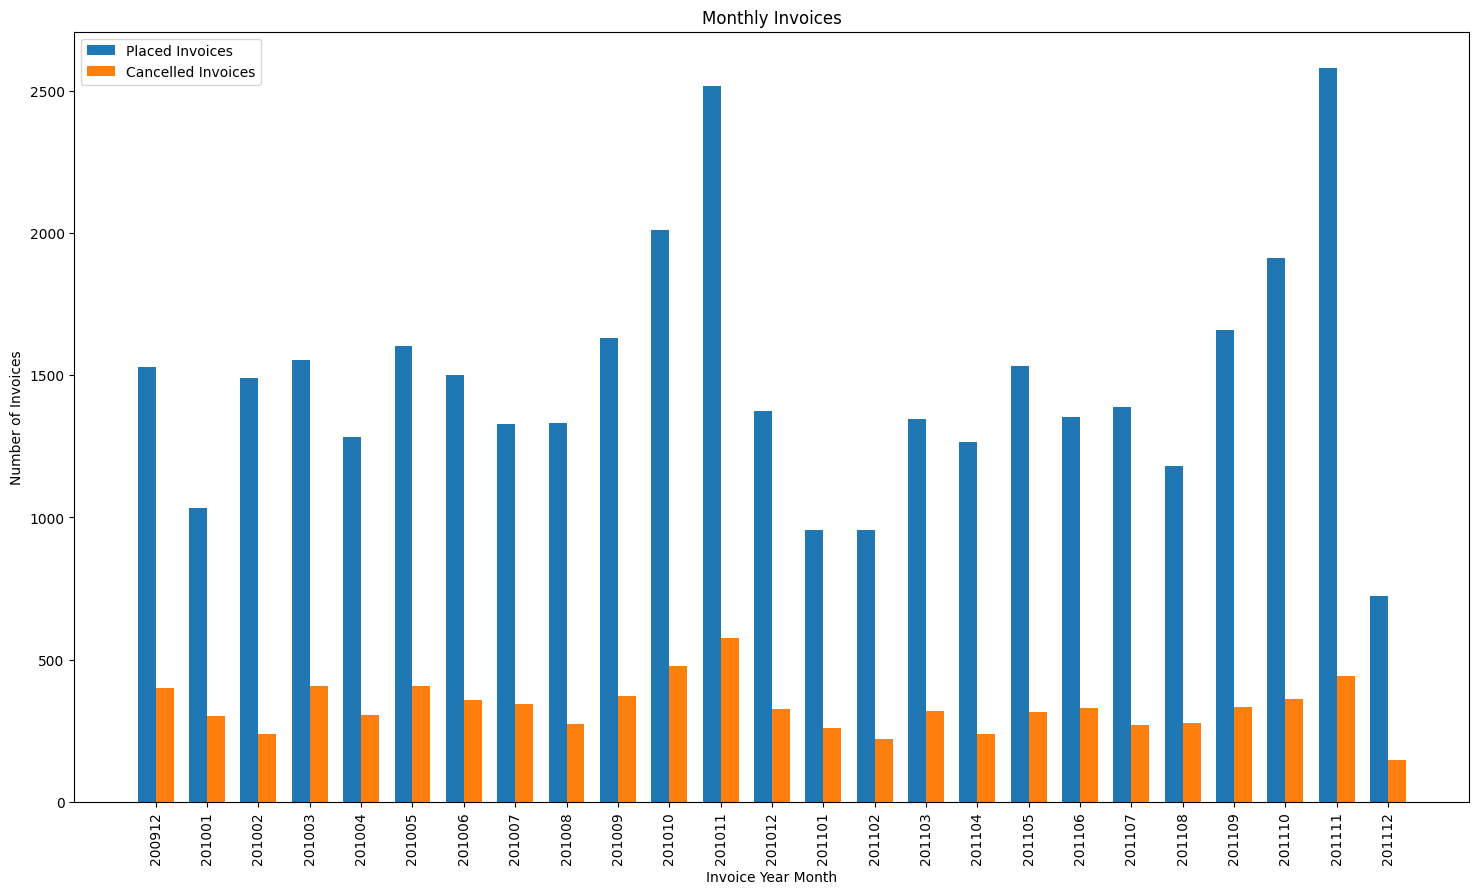

In [0]:
# Convert pyspark dataframe to pandas dataframe
monthly_pd = monthly_orders_df.toPandas()

# Specify the x-axis as the length of the "month" column
x = range(len(monthly_pd["month"]))
width = 0.35

plt.figure(figsize=(18, 10))

# Plotting the bars for placed and cancelled orders
plt.bar([i - width/2 for i in x], monthly_pd["total_invoices"], width = width, label="Placed Invoices")
plt.bar([i + width/2 for i in x], monthly_pd["cancelled_invoices_count"], width = width, label="Cancelled Invoices")
plt.xlabel("Invoice Year Month")
plt.ylabel("Number of Invoices")
plt.title("Monthly Invoices")

plt.xticks(x, monthly_pd["month"], rotation = 90)
plt.legend()
plt.show()

# Monthly Sales

Calculate monthly sales 

In [0]:
from pyspark.sql.functions import year, month, sum

monthly_sales = spark.sql("SELECT * FROM online_retail_ii")

# Create month column by combining the year and month
monthly_sales = monthly_sales.withColumn("month", year(monthly_sales.invoice_date) * 100 + month(monthly_sales.invoice_date))
# Calculate the total price for each row
monthly_sales = monthly_sales.withColumn("total_price", monthly_sales.quantity * monthly_sales.price)

# Sum the total sales per month
monthly_sales = monthly_sales.groupBy("month").agg(sum("total_price").alias("total_sales")).orderBy("month")
display(monthly_sales)


month,total_sales
200912,799847.1075055711
201001,624032.8896515106
201002,533091.424455221
201003,765848.757825097
201004,590580.4300854017
201005,615322.8286303803
201006,679786.6077747606
201007,575236.3596651554
201008,656776.3393343091
201009,853650.4293782803


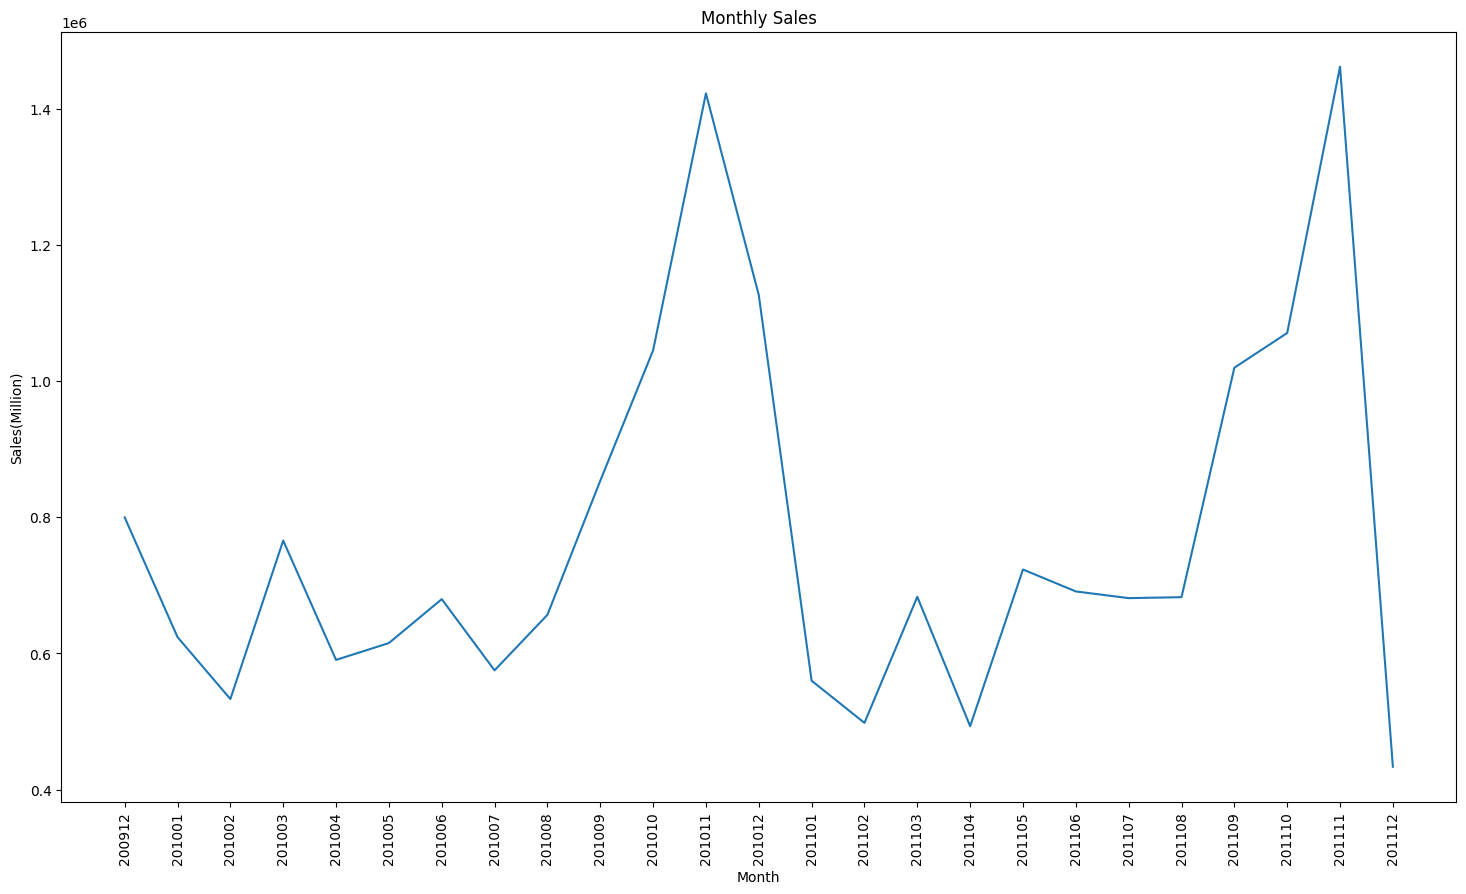

In [0]:
# Convert pyspark dataframe to pandas dataframe
monthly_sales_pd = monthly_sales.toPandas()

# Specify the x-axis as the length of the "month" column
x = range(len(monthly_sales_pd["month"]))
# Set the y-axis as the total sales column
y = monthly_sales_pd["total_sales"]

plt.figure(figsize=(18,10))

plt.plot(x, y)
plt.xlabel("Month")
plt.ylabel("Sales(Million)")
plt.title("Monthly Sales")
plt.xticks(x, monthly_sales_pd["month"], rotation = 90)

plt.show()

# Monthly Sales Growth


Calculate the growth of sales on a month to month basis

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

monthly_growth = monthly_sales

# Calculate the growth of the sales per month as a percentage by subtracting the previous month's sales from the current month's sales and dividing by the previous month's sales
monthly_growth = monthly_growth.withColumn("growth", (monthly_growth.total_sales - lag(monthly_growth.total_sales, 1).over(Window.orderBy("month"))) / lag(monthly_growth.total_sales, 1).over(Window.orderBy("month")))
monthly_growth = monthly_growth.orderBy("month")
display(monthly_growth)

month,total_sales,growth
200912,799847.1075055711,null
201001,624032.8896515106,-0.2198097813997982
201002,533091.424455221,-0.14573184635680916
201003,765848.757825097,0.43661804090684114
201004,590580.4300854017,-0.22885501340686726
201005,615322.8286303803,0.041895053212990266
201006,679786.6077747606,0.104764159795383
201007,575236.3596651554,-0.15379862873710315
201008,656776.3393343091,0.1417503923371917
201009,853650.4293782803,0.29975819507066515


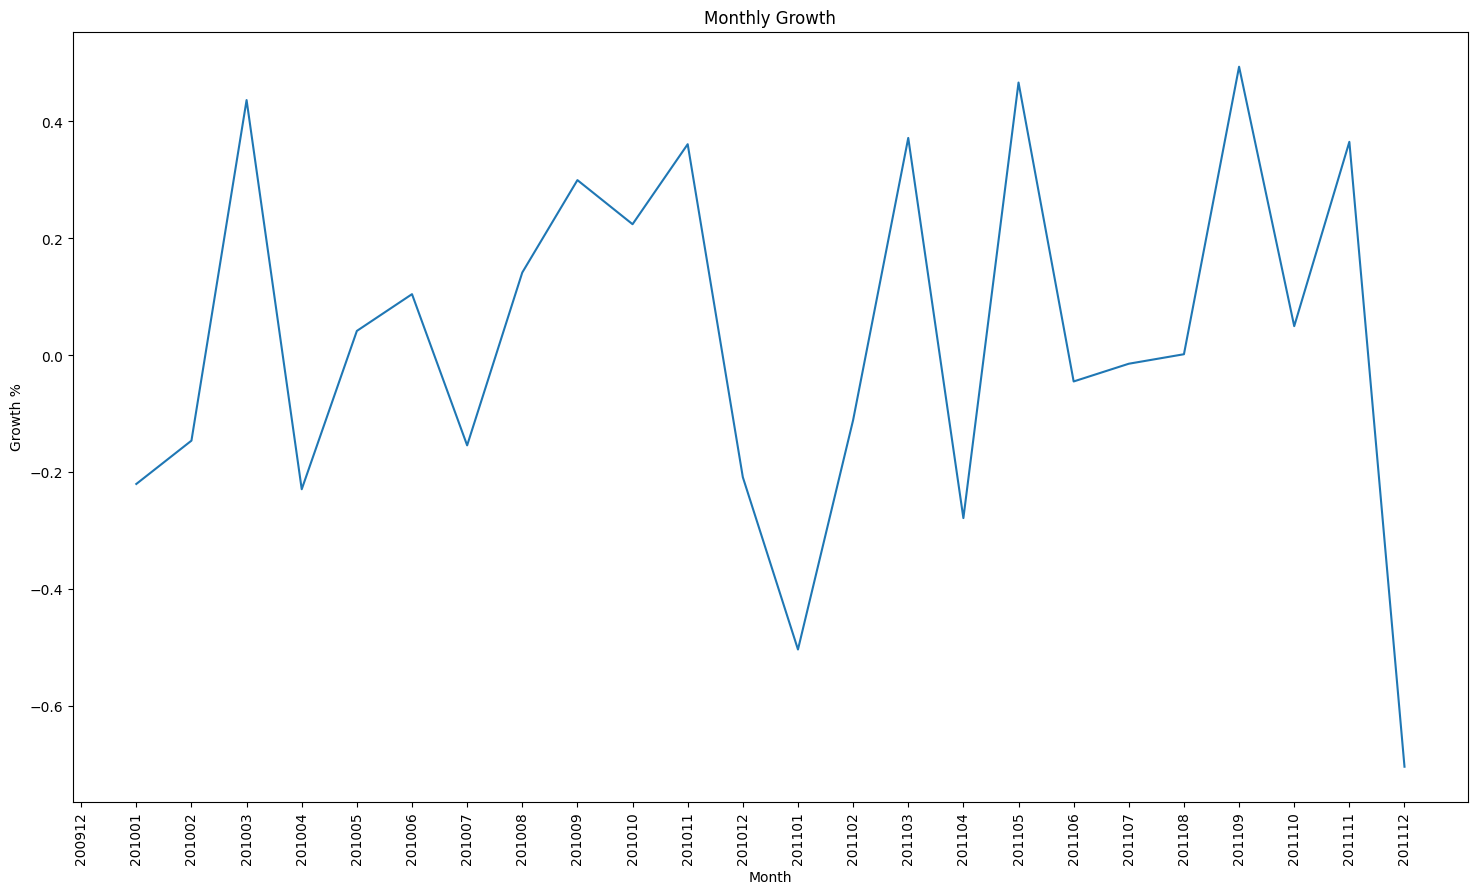

In [0]:
# Convert pyspark dataframe to pandas dataframe
monthly_growth_pd = monthly_growth.toPandas()

# Specify the x-axis as the length of the "month" column
x = range(len(monthly_growth_pd["month"]))
# Set the y-axis as the growth column
y = monthly_growth_pd["growth"]

plt.figure(figsize=(18,10))

plt.plot(x, y)
plt.xlabel("Month")
plt.ylabel("Growth %")
plt.title("Monthly Growth")
plt.xticks(x, monthly_growth_pd["month"], rotation = 90)

plt.show()

# Monthly Active Users

Show the number of active users per month

In [0]:
from pyspark.sql.functions import year, month, countDistinct

monthly_active_users = spark.sql("SELECT * FROM online_retail_ii")

# Create month column by combining the year and month
monthly_active_users = monthly_active_users.withColumn("month", year(monthly_active_users.invoice_date) * 100 + month(monthly_active_users.invoice_date))
# Calculate the number of unique customers per month
monthly_active_users = monthly_active_users.groupBy("month").agg(countDistinct("customer_id").alias("active_users")).orderBy("month")
display(monthly_active_users)

month,active_users
200912,1045
201001,786
201002,807
201003,1111
201004,998
201005,1062
201006,1095
201007,988
201008,964
201009,1202


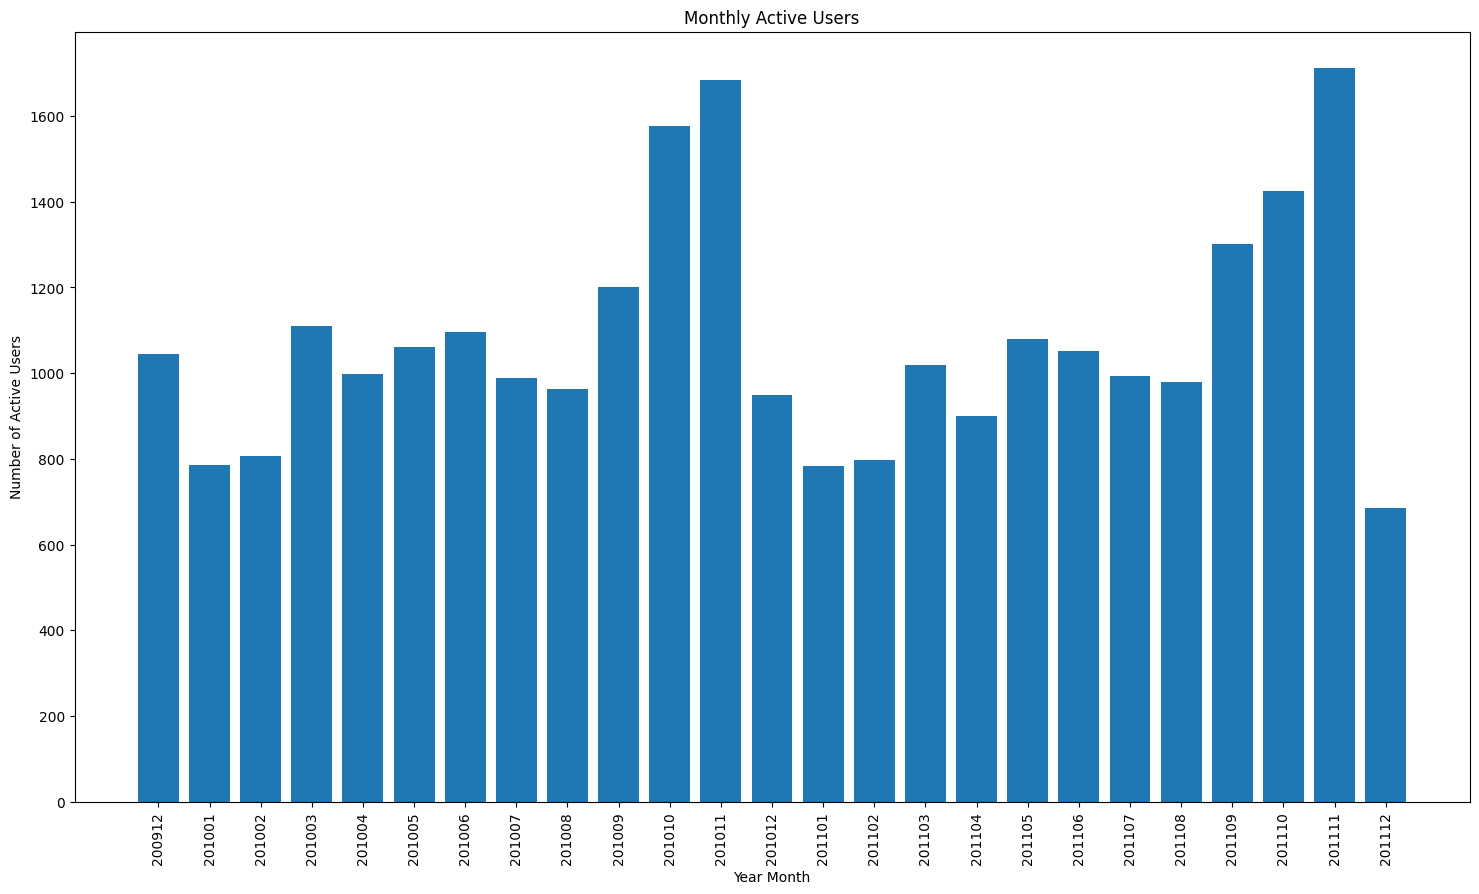

In [0]:
# Convert pyspark dataframe to pandas dataframe
monthly_active_users_pd = monthly_active_users.toPandas()

# Specify the x-axis as the length of the "month" column
x = range(len(monthly_active_users_pd["month"]))
# Set the y-axis as the active users column
y = monthly_active_users_pd["active_users"]

plt.figure(figsize=(18,10))
plt.bar(x, y, width = 0.8, label="Active Users")
plt.xlabel("Year Month")
plt.ylabel("Number of Active Users")
plt.title("Monthly Active Users")

plt.xticks(x, monthly_active_users_pd["month"], rotation = 90)
plt.show()

# New and Existing Users



Show the number of new users and existing users per month

In [0]:
from pyspark.sql.functions import min, count, countDistinct

df = spark.sql("SELECT * FROM online_retail_ii")

# Create month column by combining the year and month
df = df.withColumn("month", year(df.invoice_date) * 100 + month(df.invoice_date))

# Find the first month each customer made a purchase
new_users = df.groupBy("customer_id").agg(min("month").alias("first_order_month"))
existing_users = df.join(new_users, "customer_id", "inner")
# Filter out invoices made during a customer's first purchase month
existing_users = existing_users.filter(existing_users.month > existing_users.first_order_month)

# Calculate the number of new and existing users per month
new_users_count = new_users.groupBy("first_order_month").agg(count("customer_id").alias("new_customers_count")).orderBy("first_order_month")
existing_users_count = existing_users.groupBy("month").agg(countDistinct("customer_id").alias("existing_customers_count")).orderBy("month")

# Join the new and existing users
new_ex = existing_users_count.join(new_users_count, existing_users_count.month == new_users_count.first_order_month, "right")
new_ex = new_ex.orderBy("month")

display(new_ex)

month,existing_customers_count,first_order_month,new_customers_count
null,null,200912,1045
201001,392,201001,394
201002,444,201002,363
201003,675,201003,436
201004,707,201004,291
201005,808,201005,254
201006,826,201006,269
201007,805,201007,183
201008,806,201008,158
201009,960,201009,242


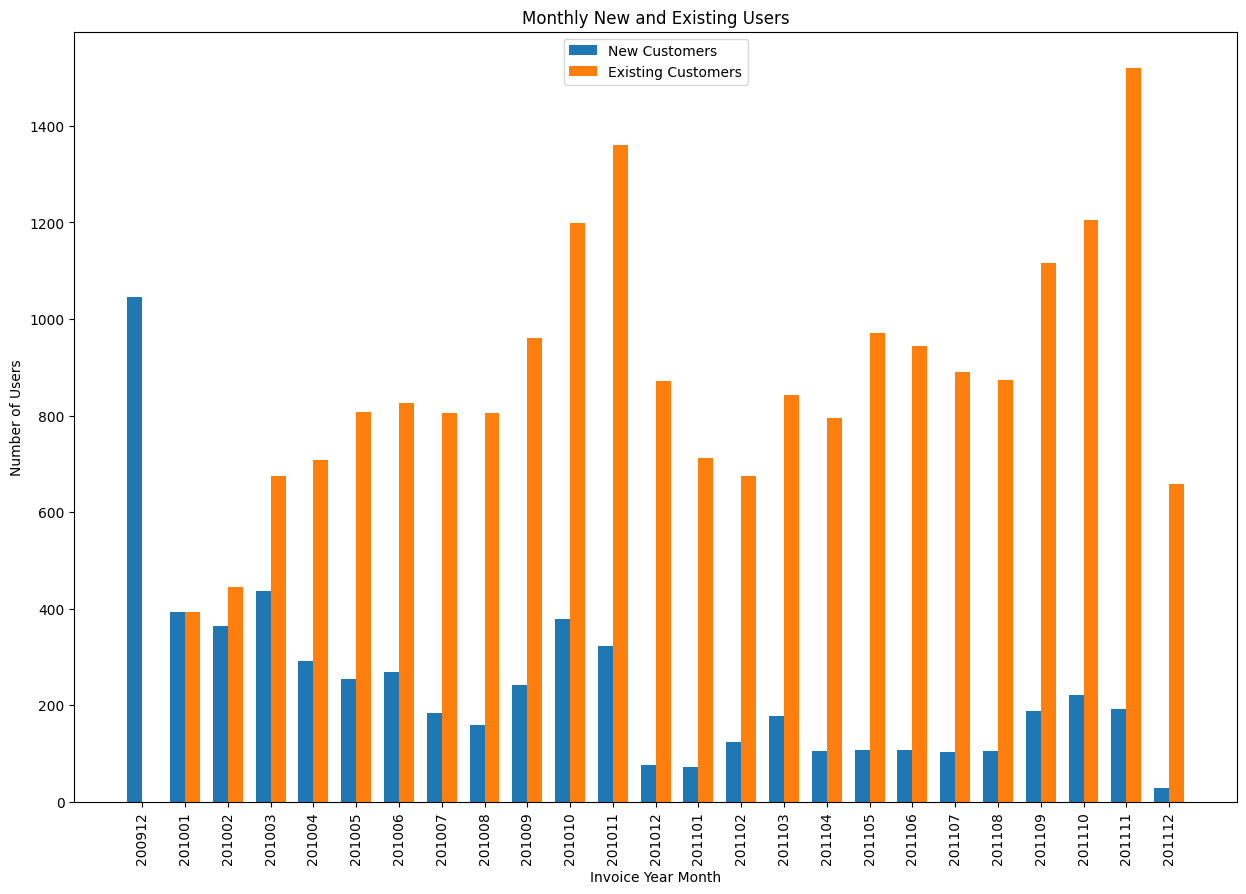

In [0]:
# Convert pyspark dataframe to pandas dataframe
new_ex_pd = new_ex.toPandas()

# Specify the x-axis as the length of the "month" column
x = range(len(new_ex_pd["first_order_month"]))
width = 0.35
plt.figure(figsize=(15,10))

# Plot the new and existing users
plt.bar([i - width/2 for i in x], new_ex_pd["new_customers_count"], width, label="New Customers")
plt.bar([i + width/2 for i in x], new_ex_pd["existing_customers_count"], width, label="Existing Customers")

plt.xlabel("Invoice Year Month")
plt.ylabel("Number of Users")
plt.title("Monthly New and Existing Users")

plt.xticks(x, new_ex_pd["first_order_month"], rotation = 90)
plt.legend()
plt.show()


## Finding RFM

RFM is a method used for analyzing customer value. It is commonly used in database marketing and direct marketing and has received particular attention in the retail and professional services industries. ([wikipedia](https://en.wikipedia.org/wiki/RFM_(market_research)))

Optional Reading: [Making Your Database Pay Off Using Recency Frequency and Monetary Analysis](http://www.dbmarketing.com/2010/03/making-your-database-pay-off-using-recency-frequency-and-monetary-analysis/)


RFM stands for three dimensions:

- Recency – How recently did the customer purchase?

- Frequency – How often do they purchase?

- Monetary Value – How much do they spend?

Note: To simplify the problem, let's keep all placed and canceled orders.


**Sample RFM table**

![](https://i.imgur.com/sXFIg6u.jpg)

In [0]:
from pyspark.sql.functions import countDistinct, sum, max, year, month, round

rfm = spark.sql("SELECT * FROM online_retail_ii WHERE customer_id IS NOT NULL")

# Create month column by combining the year and month
rfm = rfm.withColumn("month", year(rfm.invoice_date) * 100 + month(rfm.invoice_date))
# Calculate the total price for each row
rfm = rfm.withColumn("total_price", rfm.quantity * rfm.price)

# Calculate RFM metrics
rfm = rfm.groupBy("customer_id").agg( max("month").alias("recency"), countDistinct("invoice").alias("invoice_amount"), round(sum("total_price"), 2).alias("monetary")).orderBy("customer_id")
rfm.show()

+-----------+-------+--------------+--------+
|customer_id|recency|invoice_amount|monetary|
+-----------+-------+--------------+--------+
|    12346.0| 201101|            17|  -64.68|
|    12347.0| 201112|             8| 5633.32|
|    12348.0| 201109|             5|  2019.4|
|    12349.0| 201111|             5| 4404.54|
|    12350.0| 201102|             1|   334.4|
|    12351.0| 201011|             1|  300.93|
|    12352.0| 201111|            13| 1889.21|
|    12353.0| 201105|             2|  406.76|
|    12354.0| 201104|             1|  1079.4|
|    12355.0| 201105|             2|  947.61|
|    12356.0| 201111|             6| 6373.68|
|    12357.0| 201111|             3|18287.66|
|    12358.0| 201112|             5| 3887.07|
|    12359.0| 201112|            14| 8714.89|
|    12360.0| 201110|             9| 4212.89|
|    12361.0| 201102|             4|  511.25|
|    12362.0| 201112|            14| 5284.58|
|    12363.0| 201108|             2|   552.0|
|    12364.0| 201112|             

# RFM Segmentation

Segment the customers into 11 groups
- About to Sleep
- At Risk
- Can't Lose
- Champions
- Hibernating
- Loyal Customers
- Need Attention
- New Customers
- Potential Loyalists
- Promising

In [0]:
from pyspark.sql.functions import sum, max, to_date, lit, datediff, count, round
from datetime import datetime

df = spark.sql("SELECT * FROM online_retail_ii WHERE customer_id IS NOT NULL")

# Set today's date as January 1st, 2012
today = to_date(lit("2012-01-01"))

# Filter out negative quantities and prices
df = df.filter((df.quantity > 0) & (df.price > 0))

# Calculate the total price for each row
df = df.withColumn("total_price", df.quantity * df.price)

# Calculate RFM metrics
df_x = df.groupBy("customer_id").agg(round(sum("total_price"), 0).alias("Monetary"), datediff(today, max("invoice_date")).alias("Recency")).orderBy("customer_id")

# Sum the total price for each invoice
df_y = df.groupBy("customer_id", "invoice").agg(sum("total_price").alias("total_price"))

# Calculate the number of unique invoices for each customer
df_z = df_y.groupBy("customer_id").agg(count("total_price").alias("Frequency"))

rfm_table = df_x.join(df_z, "customer_id", "inner").orderBy("customer_id")

rfm_table.show()

+-----------+--------+-------+---------+
|customer_id|Monetary|Recency|Frequency|
+-----------+--------+-------+---------+
|    12346.0| 77556.0|    348|       12|
|    12347.0|  5633.0|     25|        8|
|    12348.0|  2019.0|     98|        5|
|    12349.0|  4429.0|     41|        4|
|    12350.0|   334.0|    333|        1|
|    12351.0|   301.0|    398|        1|
|    12352.0|  2850.0|     59|       10|
|    12353.0|   407.0|    227|        2|
|    12354.0|  1079.0|    255|        1|
|    12355.0|   948.0|    237|        2|
|    12356.0|  6374.0|     45|        6|
|    12357.0| 18288.0|     56|        3|
|    12358.0|  3887.0|     24|        5|
|    12359.0|  8936.0|     80|       10|
|    12360.0|  4253.0|     75|        8|
|    12361.0|   511.0|    310|        4|
|    12362.0|  5356.0|     26|       11|
|    12363.0|   552.0|    132|        2|
|    12364.0|  1313.0|     30|        4|
|    12365.0|   641.0|    314|        2|
+-----------+--------+-------+---------+
only showing top

In [0]:
# Convert pyspark dataframe to pandas dataframe
rfm_table_pd = rfm_table.toPandas()

# Group the RFM metrics into scores of 1 to 5
rfm_table_pd['RecencyScore'] = pd.qcut(rfm_table_pd['Recency'],5,labels=[5,4,3,2,1])
rfm_table_pd['FrequencyScore'] = pd.qcut(rfm_table_pd['Frequency'].rank(method="first"),5,labels=[1,2,3,4,5])
rfm_table_pd['MonetaryScore'] = pd.qcut(rfm_table_pd['Monetary'],5,labels=[1,2,3,4,5])

rfm_table_pd.head()

,customer_id,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore
0,12346.0,77556.0,348,12,2,5,5
1,12347.0,5633.0,25,8,5,4,5
2,12348.0,2019.0,98,5,3,4,4
3,12349.0,4429.0,41,4,5,3,5
4,12350.0,334.0,333,1,2,1,2


In [0]:
# Display the RFM scores for each customer
(rfm_table_pd['RecencyScore'].astype(str) + 
 rfm_table_pd['FrequencyScore'].astype(str) + 
 rfm_table_pd['MonetaryScore'].astype(str)).head()

0    255
1    545
2    344
3    535
4    212
dtype: object

In [0]:
# Create RFM score column for each customer
rfm_table_pd["RFM_SCORE"] = rfm_table_pd['RecencyScore'].astype(str) + rfm_table_pd['FrequencyScore'].astype(str) + rfm_table_pd['MonetaryScore'].astype(str)
rfm_table_pd.head()


,customer_id,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE
0,12346.0,77556.0,348,12,2,5,5,255
1,12347.0,5633.0,25,8,5,4,5,545
2,12348.0,2019.0,98,5,3,4,4,344
3,12349.0,4429.0,41,4,5,3,5,535
4,12350.0,334.0,333,1,2,1,2,212


In [0]:
#segmenting of customers according to RecencyScore and FrequencyScore values
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

#creation of segment variable
rfm_table_pd['Segment'] = rfm_table_pd['RecencyScore'].astype(str) + rfm_table_pd['FrequencyScore'].astype(str)
rfm_table_pd['Segment'] = rfm_table_pd['Segment'].replace(seg_map, regex=True)

rfm_table_pd.head()

,customer_id,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment
0,12346.0,77556.0,348,12,2,5,5,255,Can't Lose
1,12347.0,5633.0,25,8,5,4,5,545,Champions
2,12348.0,2019.0,98,5,3,4,4,344,Loyal Customers
3,12349.0,4429.0,41,4,5,3,5,535,Potential Loyalists
4,12350.0,334.0,333,1,2,1,2,212,Hibernating


In [0]:
rfm_table_pd[["Segment", "Recency","Frequency","Monetary"]].groupby("Segment").agg(["mean","count"])


Recency        Frequency            Monetary      
                           mean count       mean count          mean count
Segment                                                                   
About to Sleep       129.618557   388   1.360825   388    531.956186   388
At Risk              395.942667   750   3.904000   750   1383.584000   750
Can't Lose           353.802817    71  15.929577    71   8355.619718    71
Champions             31.250000   852  19.214789   852  10795.529343   852
Hibernating          482.012484  1522   1.252300  1522    437.960578  1522
Loyal Customers       90.306016  1147   9.802964  1147   4199.729730  1147
Need Attention       136.241636   269   3.156134   269   1283.122677   269
New Customers         33.303571    56   1.000000    56    356.196429    56
Potential Loyalists   48.297335   713   2.589060   713   1155.415147   713
Promising             61.281818   110   1.000000   110    324.481818   110